<div class="usecase-title">Ease of Travel for Young Adults</div>
<div class="usecase-authors"><b>Authored by: </b> Vivek Olladapu</div>

<div class="usecase-duration"><b>Duration:</b> 90 mins</div>

<div class="usecase-level-skill">
    <div class="usecase-level"><b>Level: </b>Intermediate</div>
    <div class="usecase-skill"><b>Pre-requisite Skills: </b>Python, matpotlib, numpy, folium</div>
</div>

<div class="usecase-section-header">Scenario</div>


Young adults (aged 18–21) in Melbourne rely heavily on public transport and active modes (walking, cycling) to get to work, study, and social activities. Understanding which suburbs offer the best accessibility to bus stops, tram stops, and bike-share docks—and where gaps in coverage exist—can inform student housing choices, campus planning, and local council investment.

In this use case, you will pull live infrastructure data from Melbourne’s Open Data portal, clean and standardise the coordinate data, compute simple accessibility metrics (e.g., distance to the nearest stop), and cluster stops to identify high-density service areas. Finally, you will visualise these patterns on interactive maps and static trend plots to highlight transit-rich neighbourhoods and underserved zones.

<div class="usecase-section-header">What this use case will teach you</div>

At the end of this use case you will:

- Fetch multi-modal transport data (bus stops, tram stops, bike-share docks) using Melbourne’s Open Data APIs.

- Clean and standardise raw geospatial tables in pandas: remove duplicates, drop missing points, and split text-based coordinates into numeric lat/lon.

- Compute accessibility metrics, such as geodesic distance to the nearest stop for any given location.

- Cluster transport stops to reveal high-density service areas using simple radius-based or scikit-learn clustering.

- Build interactive maps in Folium with MarkerCluster and HeatMap layers to explore spatial coverage.

- Create static plots in Matplotlib/Seaborn to compare stop densities across suburbs.

- Identify transit deserts—areas underserved by public transport—and recommend neighbourhoods for service improvements.

- Combine multiple layers (bus, tram, bike) into a cohesive, multi-modal accessibility dashboard.

# Importing Required Libraries

In [54]:
!pip install geopy
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import folium
from folium import Map, Marker, FeatureGroup, LayerControl
from folium.plugins import MarkerCluster, HeatMap
from geopy.distance import geodesic
import requests
from io import StringIO

# Importing Datasets

Reading first data set through API for the bus_stops

In [58]:
# Set the base URL and dataset ID for Melbourne Open Data
base_url = 'https://data.melbourne.vic.gov.au/api/explore/v2.1/catalog/datasets/'
dataset_id = 'bus-stops'
# Build the full export URL for CSV format
url = f'{base_url}{dataset_id}/exports/csv'
# Define parameters for the API request
params = {
    'select': '*',
    'limit': -1,
    'lang': 'en',
    'timezone': 'UTC'
}
# Send request to the API
response = requests.get(url, params=params)

# Check if the request was successful
if response.status_code == 200:
    # Read the CSV content into a DataFrame
    url_content = response.content.decode('utf-8')
    bus_stops = pd.read_csv(StringIO(url_content), delimiter=';')
    # Print first 10 rows
    print(bus_stops.head(10))
else:
    # Print error message if request fails
    print(f'Request failed with status code {response.status_code}')

                              geo_point_2d  \
0   -37.80000725498236, 144.96097934573706   
1  -37.807815885141665, 144.91663837870203   
2   -37.82500188553457, 144.95694945167727   
3   -37.79859348300079, 144.94845845599968   
4  -37.800561849475905, 144.96449089849344   
5   -37.82168352630472, 144.96129766991564   
6     -37.8338230491092, 144.9795143710974   
7  -37.794769078965565, 144.92642079506638   
8   -37.803343440196116, 144.9693670992385   
9   -37.81570404359276, 144.96116717702685   

                                           geo_shape  prop_id  addresspt1  \
0  {"coordinates": [144.96097934573706, -37.80000...        0   39.387723   
1  {"coordinates": [144.91663837870203, -37.80781...        0   80.959563   
2  {"coordinates": [144.95694945167727, -37.82500...        0   85.169791   
3  {"coordinates": [144.94845845599968, -37.79859...        0   42.168240   
4  {"coordinates": [144.96449089849344, -37.80056...        0   32.129118   
5  {"coordinates": [144.9612976

The result shows the first ten records from Melbourne’s “bus-stops” dataset. Each row includes a geo_point_2d string (the stop’s latitude and longitude) alongside a geo_shape JSON object with the same co-ordinates. The various ID columns (prop_id, objectid, mcc_id, etc.) link this signage asset to address and council databases, while asset_class and asset_type describe it as “Signage – Public Transport.” Descriptive fields like model_desc and model_no tell you the exact sign-panel type, and roadseg_id identifies the street segment where the sign is located.

Reading first data set through API for the tram_stops

In [62]:
# Set the base URL and dataset ID for Melbourne Open Data
base_url = 'https://data.melbourne.vic.gov.au/api/explore/v2.1/catalog/datasets/'
dataset_id = 'city-circle-tram-stops'
# Build the full export URL for CSV format
url = f'{base_url}{dataset_id}/exports/csv'
# Define parameters for the API request
params = {
    'select': '*',
    'limit': -1,
    'lang': 'en',
    'timezone': 'UTC'
}
# Send request to the API
response = requests.get(url, params=params)

# Check if the request was successful
if response.status_code == 200:
    # Read the CSV content into a DataFrame
    url_content = response.content.decode('utf-8')
    tram_stops = pd.read_csv(StringIO(url_content), delimiter=';')
    # Print first 10 rows
    print(tram_stops.head(10))
else:
    # Print error message if request fails
    print(f'Request failed with status code {response.status_code}')

                              geo_point_2d  \
0   -37.81667338583987, 144.97015587085124   
1  -37.813414856197724, 144.94137823870162   
2  -37.814591782869805, 144.94655055842398   
3   -37.81538859129167, 144.97453393804187   
4   -37.82023778673241, 144.95786314283018   
5  -37.808876998255194, 144.96634474519394   
6   -37.81358116790275, 144.97406360491075   
7    -37.8176316450406, 144.96690455927876   
8   -37.81865571347738, 144.94650837136655   
9   -37.80956201428191, 144.97291405751537   

                                           geo_shape  \
0  {"coordinates": [144.97015587085124, -37.81667...   
1  {"coordinates": [144.94137823870162, -37.81341...   
2  {"coordinates": [144.94655055842398, -37.81459...   
3  {"coordinates": [144.97453393804187, -37.81538...   
4  {"coordinates": [144.95786314283018, -37.82023...   
5  {"coordinates": [144.96634474519394, -37.80887...   
6  {"coordinates": [144.97406360491075, -37.81358...   
7  {"coordinates": [144.96690455927876, -37.8

The result shows the first ten records from Melbourne’s “city‐circle‐tram‐stops” dataset. Each row begins with geo_point_2d, a text string of the stop’s co-ordinates (latitude, longitude), and geo_shape, a GeoJSON object containing the same point. The name column gives the tram stop’s location, while xorg lists the owning organisation (“GIS Team”). The stop_no field is the stop’s numeric code and xsource indicates the data source (Mapbase). The xdate column records when the data was captured (18 October 2011), and mccid_str/mccid_int are Melbourne City Council identifiers. This mix of spatial co-ordinates and metadata lets you accurately map each tram stop and link it to council records.

Reading first data set through API for the bike_docks

In [66]:
# Set the base URL and dataset ID for Melbourne Open Data
base_url = 'https://data.melbourne.vic.gov.au/api/explore/v2.1/catalog/datasets/'
dataset_id = 'bike-share-dock-locations'
# Build the full export URL for CSV format
url = f'{base_url}{dataset_id}/exports/csv'
# Define parameters for the API request
params = {
    'select': '*',
    'limit': -1,
    'lang': 'en',
    'timezone': 'UTC'
}
# Send request to the API
response = requests.get(url, params=params)

# Check if the request was successful
if response.status_code == 200:
    # Read the CSV content into a DataFrame
    url_content = response.content.decode('utf-8')
    bike_docks = pd.read_csv(StringIO(url_content), delimiter=';')
    # Print first 10 rows
    print(bike_docks.head(10))
else:
    # Print error message if request fails
    print(f'Request failed with status code {response.status_code}')

   station_id                                               name  \
0          21            Bridport St / Montague St - Albert Park   
1          22            Pickles St / Ingles St - Port Melbourne   
2          26                          Beach St - Port Melbourne   
3          40      Rod Laver Arena - Batman Ave / Swan St - City   
4          47    VCAM - St Kilda Rd / Southbank Blvd - Southbank   
5          49  Jolimont Station - Wellington Pde South - East...   
6          52       Flagstaff Gardens - Peel St - West Melbourne   
7           4                 Arts Centre - St Kilda Road - City   
8          12              Fitzroy Town Hall - Moor St - Fitzroy   
9          17  Yarra's Point - Lorimer St / Yarra River - Doc...   

    rental_method  capacity        lat         lon  \
0  CREDITCARD,KEY        23 -37.840885  144.955303   
1  CREDITCARD,KEY        23 -37.835803  144.948520   
2  CREDITCARD,KEY        39 -37.841954  144.935296   
3  CREDITCARD,KEY        23 -37.822

The result shows the first ten records from Melbourne’s bike-share dock dataset. Each row begins with a station_id (the unique dock identifier) and name (its street intersection or nearby landmark). The rental_method column tells you how users access the bikes (e.g. CREDITCARD, KEY), while capacity is the total number of docks available. The lat and lon fields are the numeric co-ordinates, and the original location string repeats those values. Altogether, this table gives you both the spatial co-ordinates and key metadata needed to map and analyse bike-share accessibility across the city.

# Data Preprocessing and Exploratory Data Analysis

In [70]:
# 1. Drop duplicates & any rows without a coordinate
bus_stops_clean = (
    bus_stops
    .drop_duplicates()
    .dropna(subset=['geo_point_2d'])
    .copy()
)

# 2. Split the "lat,lon" text into numeric columns
bus_stops_clean[['lat','lon']] = (
    bus_stops_clean['geo_point_2d']
      .str.split(',', expand=True)
      .astype(float)
)

# 3. Drop the original coordinate columns
bus_stops_clean = bus_stops_clean.drop(
    columns=['geo_point_2d', 'geo_shape'],
    errors='ignore'
)

# 4. Reset the index
bus_stops_clean = bus_stops_clean.reset_index(drop=True)

# Quick sanity check
print("Bus stops cleaned:", bus_stops_clean.shape)
bus_stops_clean.head()


Bus stops cleaned: (309, 16)


,prop_id,addresspt1,addressp_1,asset_clas,asset_type,objectid,str_id,addresspt,asset_subt,model_desc,mcc_id,roadseg_id,descriptio,model_no,lat,lon
0,0,39.387723,296,Signage,Sign - Public Transport,5005,1575590,518481,NaN,Sign - Public Transport 1 Panel,1575590,20461,Sign - Public Transport 1 Panel Bus Stop Type 1,P.16,-37.800007,144.960979
1,0,80.959563,127,Signage,Sign - Public Transport,6298,1236305,104048,NaN,Sign - Public Transport 1 Panel,1236305,22443,Sign - Public Transport 1 Panel Bus Stop Type 11,P.16,-37.807816,144.916638
2,0,85.169791,277,Signage,Sign - Public Transport,8264,1232805,622450,NaN,Sign - Public Transport 1 Panel,1232805,22454,Sign - Public Transport 1 Panel Bus Stop Type 8,P.16,-37.825002,144.956949
3,0,42.168240,297,Signage,Sign - Public Transport,8970,1249876,638970,NaN,Sign - Public Transport 1 Panel,1249876,21168,Sign - Public Transport 1 Panel Bus Stop Type 12,P.16,-37.798593,144.948458
4,0,32.129118,42,Signage,Sign - Public Transport,9175,1575585,104469,NaN,Sign - Public Transport 1 Panel,1575585,22506,Sign - Public Transport 1 Panel Bus Stop Type 1,P.16,-37.800562,144.964491


The cleaned bus_stops_clean table contains 309 unique signage records, each retaining its key metadata (e.g. prop_id, addresspt1, asset_type, model_desc, etc.) alongside two precise numeric columns, lat and lon. All duplicate rows and any entries without valid geo_point_2d co-ordinates have been removed, and the original geo_point_2d/geo_shape fields dropped. The index has been reset to a zero-based sequence, yielding a tidy DataFrame of bus-stop locations ready for mapping or further spatial analysis.

In [73]:

tram_stops_clean = (
    tram_stops
    .drop_duplicates()
    .dropna(subset=['geo_point_2d'])
    .copy()
)
tram_stops_clean[['lat','lon']] = (
    tram_stops_clean['geo_point_2d']
      .str.split(',', expand=True)
      .astype(float)
)
tram_stops_clean = tram_stops_clean.drop(columns=['geo_point_2d','geo_shape'], errors='ignore')
tram_stops_clean = tram_stops_clean.reset_index(drop=True)

print("Tram stops cleaned:", tram_stops_clean.shape)
tram_stops_clean.head()


Tram stops cleaned: (28, 9)


,name,xorg,stop_no,mccid_str,xsource,xdate,mccid_int,lat,lon
0,Russell Street / Flinders Street,GIS Team,6,NaN,Mapbase,2011-10-18,28,-37.816673,144.970156
1,New Quay Promenade / Docklands Drive,GIS Team,D10,NaN,Mapbase,2011-10-18,11,-37.813415,144.941378
2,Etihad Statium / La Trobe Street,GIS Team,D1,NaN,Mapbase,2011-10-18,13,-37.814592,144.946551
3,Spring Street / Flinders Street,GIS Team,8,NaN,Mapbase,2011-10-18,26,-37.815389,144.974534
4,Melbourne Aquarium / Flinders Street,GIS Team,2,NaN,Mapbase,2011-10-18,4,-37.820238,144.957863


The cleaned tram_stops_clean table comprises 28 unique City-Circle tram-stop records, each with essential fields (name, xorg, stop_no, xdate, etc.) plus the newly created lat and lon floats. Any duplicates or rows missing the original geo_point_2d co-ordinates have been discarded, and the geo_point_2d/geo_shape columns removed. The index has been reset so you have a neat, zero-based list of tram stops prepared for visualisation or distance-based computations.

In [76]:

bike_docks_clean = (
    bike_docks
    .drop_duplicates()
    .assign(
        lat=lambda df: pd.to_numeric(df['lat'], errors='coerce'),
        lon=lambda df: pd.to_numeric(df['lon'], errors='coerce')
    )
    .dropna(subset=['lat','lon'])         # drop any that still failed to parse
    .drop(columns=['location'], errors='ignore')  # remove raw text coord column
    .reset_index(drop=True)
)

print("Bike docks cleaned:", bike_docks_clean.shape)
bike_docks_clean.head()


Bike docks cleaned: (50, 6)


,station_id,name,rental_method,capacity,lat,lon
0,21,Bridport St / Montague St - Albert Park,"CREDITCARD,KEY",23,-37.840885,144.955303
1,22,Pickles St / Ingles St - Port Melbourne,"CREDITCARD,KEY",23,-37.835803,144.948520
2,26,Beach St - Port Melbourne,"CREDITCARD,KEY",39,-37.841954,144.935296
3,40,Rod Laver Arena - Batman Ave / Swan St - City,"CREDITCARD,KEY",23,-37.822987,144.978459
4,47,VCAM - St Kilda Rd / Southbank Blvd - Southbank,"CREDITCARD,KEY",11,-37.824088,144.970085


The cleaned bike_docks_clean table contains 50 unique stations, each with only the key metadata (station_id, name, rental_method, capacity) and two precise numeric columns (lat and lon). All duplicates and any rows lacking valid coordinates have been removed, and the original text-based location column has been dropped. The index has been reset to a zero-based sequence, resulting in a tidy DataFrame of dock locations ready for mapping or spatial analysis.

# Plotting Public Transport Coverage in Melbourne

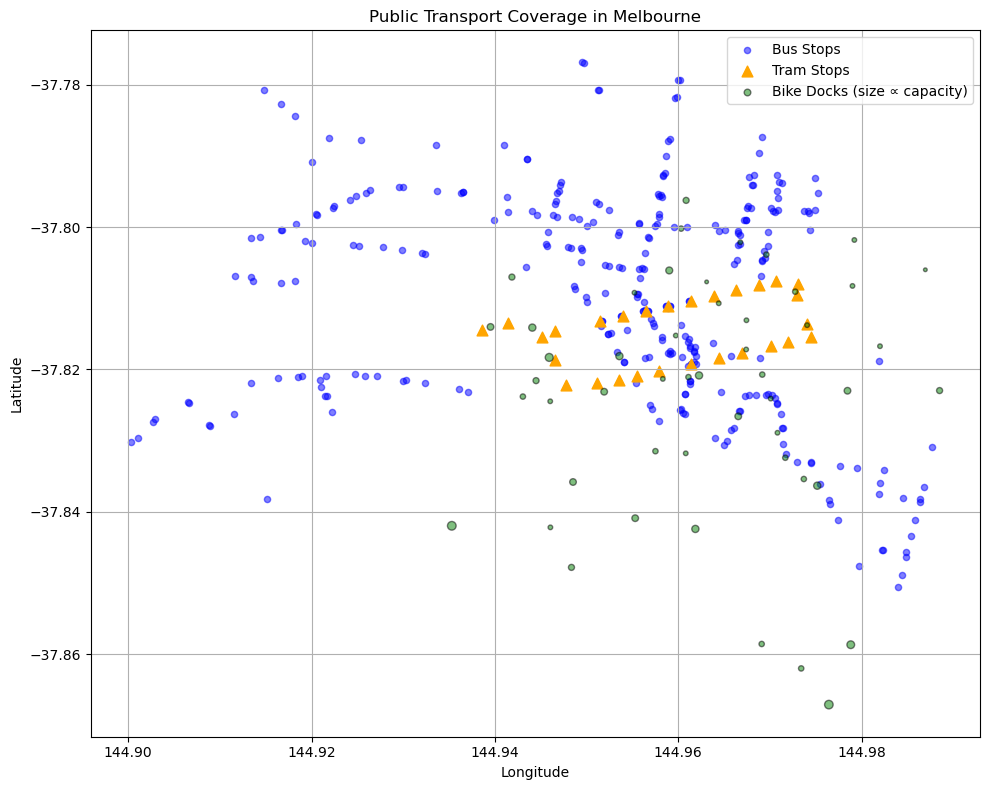

In [80]:

plt.figure(figsize=(10, 8))
plt.scatter(bus_stops_clean['lon'], bus_stops_clean['lat'], s=20, c='blue', alpha=0.5, label='Bus Stops')
plt.scatter(tram_stops_clean['lon'], tram_stops_clean['lat'], s=60, c='orange', marker='^', label='Tram Stops')
plt.scatter(bike_docks_clean['lon'], bike_docks_clean['lat'], s=bike_docks_clean['capacity'], c='green', alpha=0.5, edgecolor='black', label='Bike Docks (size ∝ capacity)')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Public Transport Coverage in Melbourne')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

The chart plots every bus stop (blue dots), tram stop (orange triangles), and bike‐share dock (green circles sized by capacity) across inner Melbourne, using longitude on the x-axis and latitude on the y-axis. You can see that bus stops form a broad grid reaching well into the suburbs, while tram stops tightly follow the City Circle route through the CBD and Docklands. Bike docks, though fewer, cluster around the city centre, with larger capacity stations closest to the heart of town. This overlay instantly highlights transit-rich corridors-areas where all three modes converge-and reveals coverage gaps, such as suburban pockets with buses but no bike docks or tram access, guiding where to prioritise new infrastructure for better multi-modal accessibility.

# HeatMap to explore spatial coverage

In [84]:

import folium
from folium import Map, Marker, FeatureGroup, LayerControl

# Helper
def extract_lat_lon(geo_point):
    try:
        lat, lon = geo_point.split(',')
        return float(lat), float(lon)
    except:
        return None, None

# Base map
melbourne_map = Map(location=[-37.8136, 144.9631], zoom_start=13)

bus_layer = FeatureGroup(name="Bus Stops")
for lat, lon in zip(bus_stops_clean['lat'], bus_stops_clean['lon']):
    Marker([lat, lon], icon=folium.Icon(color='blue', icon='bus', prefix='fa')).add_to(bus_layer)

tram_layer = FeatureGroup(name="Tram Stops")
for lat, lon in zip(tram_stops_clean['lat'], tram_stops_clean['lon']):
    Marker([lat, lon], icon=folium.Icon(color='orange', icon='train', prefix='fa')).add_to(tram_layer)

bike_layer = FeatureGroup(name="Bike Share")
for _, row in bike_docks_clean.iterrows():
    Marker([row['lat'], row['lon']], icon=folium.Icon(color='green', icon='bicycle', prefix='fa')).add_to(bike_layer)

bus_layer.add_to(melbourne_map)
tram_layer.add_to(melbourne_map)
bike_layer.add_to(melbourne_map)
LayerControl().add_to(melbourne_map)

melbourne_map.save("melbourne_transport_map.html")
melbourne_map


The interactive Folium map displays all three transport layers over central Melbourne. Blue bus-stop icons cluster tightly around the CBD and inner suburbs, orange tram icons trace the City Circle loop, and green bicycle icons mark the bike-share docks, with larger icons indicating higher capacity. You can toggle each layer on and off via the control in the top-right, and zoom or pan to explore coverage in different neighbourhoods. This map makes it easy to spot where bus, tram, and bike services overlap—creating high-accessibility zones—and where gaps remain, guiding decisions about where to add new stops or docks.